# Building RNN network from Scratch in Python

- Input: A sequence of numbers
- Output: Single scalar => Next value in the sequence


In [13]:
import math
from matplotlib import pyplot as plt
import numpy as np
import random

def get_sin_wave(noise = 0.05, points = 500):
    
    sin_wave = []
    c = 0
    for i in range(points):
        n = random.random()*noise
        sin_wave.append(c*i*0.01+math.sin(i*0.5+n))
    
    sin_wave = np.array(sin_wave)
    
    return sin_wave

In [14]:
seq_len = 10

def get_Data(sin_wave):
    X = []
    Y = []
    num_records = len(sin_wave) - seq_len

    for i in range(num_records):
        X.append(sin_wave[i:i+seq_len])
        Y.append(sin_wave[i+seq_len])

    X = np.array(X)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=1)
    
    return X,Y


# Data preparation

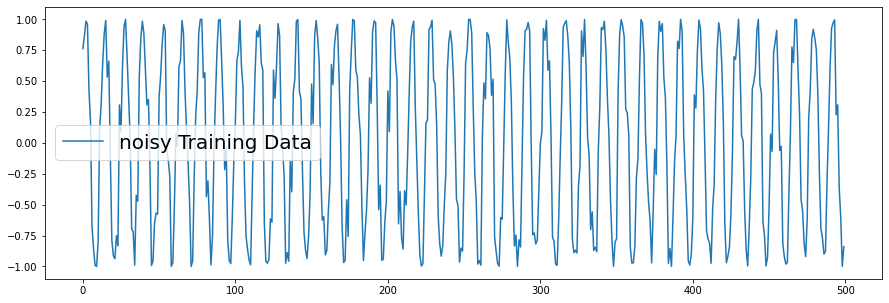

(490, 10, 1) (490, 1)


In [15]:
# Training Data

sin_wave = get_sin_wave(noise=1.0)
plt.figure(figsize=(15, 5))
plt.plot(sin_wave, label='noisy Training Data')
plt.legend(fontsize=20)
plt.show()

X,Y = get_Data(sin_wave)
print(X.shape, Y.shape)

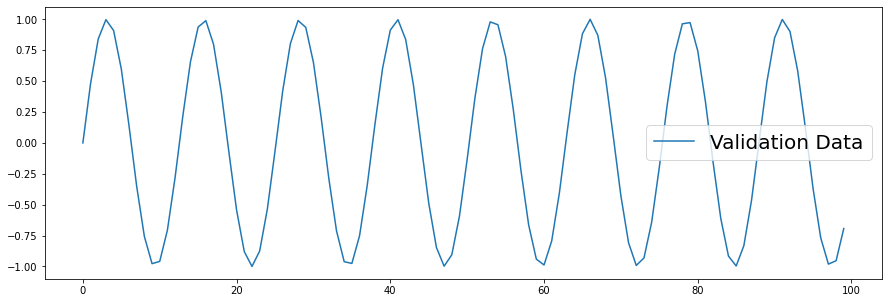

(90, 10, 1) (90, 10, 1)


In [16]:
# Validation Data

sin_wave_val= get_sin_wave(noise=0.0,points = 100)

plt.figure(figsize=(15, 5))
plt.plot(sin_wave_val, label='Validation Data')
plt.legend(fontsize=20)
plt.show()

# Training Data
X_val,Y_val = get_Data(sin_wave_val)
print(X_val.shape, X_val.shape)

# Now creating an RNN model
- Model takes in the input sequence, process it through a hidden layer of 100 units, and produce a single output

In [17]:
# create RNN architecture
learning_rate = 0.0001
#seq_len = 50
max_epochs = 20
hidden_dim = 100
output_dim = 1
bptt_truncate = 5 # backprop through time --> lasts 5 iterations
min_clip_val = -5
max_clip_val = 5

In [18]:
U = np.random.uniform(0, 1, (hidden_dim,seq_len))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))
print(U.shape, W.shape, V.shape)

(100, 10) (100, 100) (1, 100)


In [19]:
# Activation of hidden layer
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Train the Model
## Check loss on training data
- Forward pass
- calculate error

## Check loss of validation data
- Forward pass
- Calculate error

## Training
- Forward pass
- Back-propagation
- Update weights

In [20]:
def calculate_loss(X, Y, U, V, W):
    loss = 0.0
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_activation = np.zeros((hidden_dim, 1)) # value of previous activation
        for timestep in range(seq_len):
            new_input = np.zeros(x.shape) # forward pass, done for each step in the sequence
            new_input[timestep] = x[timestep] # define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_activation)
            _sum = mulu + mulw
            activation = sigmoid(_sum)
            mulv = np.dot(V, activation)
            prev_activation = activation
        # calculate and add loss per record
        loss_per_record = float((y - mulv)**2/2)
        loss += loss_per_record
    # calculate loss after first Y pass
    return loss, activation

In [21]:
# takes x values and the weights matrices
# returns layer dictionary, final weights (mulu, mulw, mulv)
def calc_layers(x, U, V, W, prev_activation):
    layers = []
    for timestep in range(seq_len):
        new_input = np.zeros(x.shape)
        new_input[timestep] = x[timestep]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_activation)
        _sum = mulw + mulu
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        layers.append({'activation': activation, 'prev_activation': prev_activation})
        prev_activation = activation
 
    return layers, mulu, mulw, mulv
                
                 
def backprop(x, U, V, W, dmulv, mulu, mulw, layers):
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
   
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
   
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
   
    _sum = mulu + mulw
    dsv = np.dot(np.transpose(V), dmulv)
   
    def get_previous_activation_differential(_sum, ds, W):
        d_sum = _sum * (1 - _sum) * ds
        dmulw = d_sum * np.ones_like(ds)
        return np.dot(np.transpose(W), dmulw)
   
    for timestep in range(seq_len):
        dV_t = np.dot(dmulv, np.transpose(layers[timestep]['activation']))
        ds = dsv
        dprev_activation = get_previous_activation_differential(_sum, ds, W)
       
        for _ in range(timestep-1, max(-1, timestep-bptt_truncate-1), -1):
            ds = dsv + dprev_activation
            dprev_activation = get_previous_activation_differential(_sum, ds, W)
            dW_i = np.dot(W, layers[timestep]['prev_activation'])
           
            new_input = np.zeros(x.shape)
            new_input[timestep] = x[timestep]
            dU_i = np.dot(U, new_input)
           
            dU_t += dU_i
            dW_t += dW_i
           
        dU += dU_t
        dV += dV_t
        dW += dW_t
       
        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
       
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
       
    return dU, dV, dW

In [22]:
# training
def train(U, V, W, X, Y, X_validation, Y_validation):
    for epoch in range(max_epochs):
        # calculate initial loss, ie what the output is given a random set of weights
        loss, prev_activation = calculate_loss(X, Y, U, V, W)
 
        # check validation loss
        val_loss, _ = calculate_loss(X_validation, Y_validation, U, V, W)
       
        print(f'Epoch: {epoch+1}, Loss: {loss}, Validation Loss: {val_loss}')
 
        # train model/forward pass
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]
            layers = []
            prev_activation = np.zeros((hidden_dim, 1))
           
            layers, mulu, mulw, mulv = calc_layers(x, U, V, W, prev_activation)
               
            # difference of the prediction
            dmulv = mulv - y
            dU, dV, dW = backprop(x, U, V, W, dmulv, mulu, mulw, layers)
           
            # update weights
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW
    return U, V, W

In [23]:
U, V, W = train(U, V, W, X, Y, X_val, Y_val)

Epoch: 1, Loss: 702500.4798132288, Validation Loss: 129208.31605562333
Epoch: 2, Loss: 206777.00486812578, Validation Loss: 38076.17371197262
Epoch: 3, Loss: 2266.7758666317536, Validation Loss: 418.7329840306943
Epoch: 4, Loss: 158.61350682161833, Validation Loss: 30.233294380999652
Epoch: 5, Loss: 156.76590279845942, Validation Loss: 29.848924757918216
Epoch: 6, Loss: 154.92999211431516, Validation Loss: 29.46670599924974
Epoch: 7, Loss: 153.12634327604968, Validation Loss: 29.090144112039933
Epoch: 8, Loss: 151.35339942294152, Validation Loss: 28.719453517919575
Epoch: 9, Loss: 149.61639565606274, Validation Loss: 28.355681825024476
Epoch: 10, Loss: 147.9044815097069, Validation Loss: 27.99737030998169
Epoch: 11, Loss: 146.22974021956927, Validation Loss: 27.646811758213506
Epoch: 12, Loss: 144.6069713569604, Validation Loss: 27.306741457900788
Epoch: 13, Loss: 143.03648730736916, Validation Loss: 26.977377743016323
Epoch: 14, Loss: 141.52785094806262, Validation Loss: 26.6606651944

# Get predictions

In [24]:
def get_predictions(X, T):
    global U, V, W
    preds = []
    for i in range(X.shape[0]):
        x = X[i]
        prev_s = np.zeros((hidden_dim, 1))
        # Forward pass
        for t in range(T):
            mulu = np.dot(U, x)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
            
        preds.append(mulv)

    preds = np.array(preds)
    return preds

In [25]:
y_pred = get_predictions(X,seq_len)
print(y_pred.shape)

(490, 1, 1)


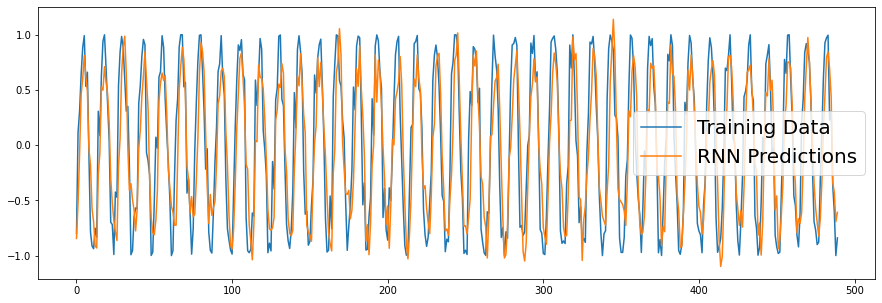

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(Y[:,0], label='Training Data')
plt.plot(y_pred[:,0,0], label='RNN Predictions')
plt.legend(fontsize=20)
plt.show()

# Using GRU cell from Keras

In [27]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

/Users/sandeep/miniconda3/envs/mango/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sandeep/miniconda3/envs/mango/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sandeep/miniconda3/envs/mango/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sandeep/miniconda3/envs/mango/lib

Instructions for updating:
non-resource variables are not supported in the long term


/Users/sandeep/miniconda3/envs/mango/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sandeep/miniconda3/envs/mango/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sandeep/miniconda3/envs/mango/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sandeep/mini

In [28]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(X.shape[1], X.shape[2])))
model.add(tf.keras.layers.GRU(16, activation='relu'))
model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                864       
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X[:350], Y[:350], batch_size=64, epochs=100,
            verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
350/350 [==============================] - 1s 1ms/sample - loss: 0.4359
Epoch 2/100
350/350 [==============================] - 0s 110us/sample - loss: 0.4155
Epoch 3/100
350/350 [==============================] - 0s 106us/sample - loss: 0.3967
Epoch 4/100
350/350 [==============================] - 0s 100us/sample - loss: 0.3788
Epoch 5/100
350/350 [==============================] - 0s 98us/sample - loss: 0.3628
Epoch 6/100
350/350 [==============================] - 0s 99us/sample - loss: 0.3471
Epoch 7/100
350/350 [==============================] - 0s 103us/sample - loss: 0.3333
Epoch 8/100
350/350 [==============================] - 0s 101us/sample - loss: 0.3199
Epoch 9/100
350/350 [==============================] - 0s 97us/sample - loss: 0.3058
Epoch 10/100
350/350 [==============================] - 0s 109us/sample - loss: 0.2919
Epoch 11/100
350/350 [============================

350/350 [==============================] - 0s 101us/sample - loss: 0.0517
Epoch 92/100
350/350 [==============================] - 0s 104us/sample - loss: 0.0518
Epoch 93/100
350/350 [==============================] - 0s 96us/sample - loss: 0.0518
Epoch 94/100
350/350 [==============================] - 0s 96us/sample - loss: 0.0515
Epoch 95/100
350/350 [==============================] - 0s 94us/sample - loss: 0.0515
Epoch 96/100
350/350 [==============================] - 0s 96us/sample - loss: 0.0516
Epoch 97/100
350/350 [==============================] - 0s 93us/sample - loss: 0.0514
Epoch 98/100
350/350 [==============================] - 0s 94us/sample - loss: 0.0514
Epoch 99/100
350/350 [==============================] - 0s 94us/sample - loss: 0.0517
Epoch 100/100
350/350 [==============================] - 0s 94us/sample - loss: 0.0515


In [30]:
y_pred = model.predict(X)

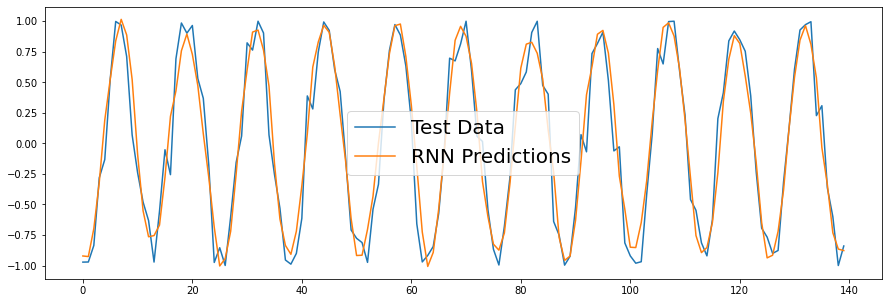

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(Y[350:,0], label='Test Data')
plt.plot(y_pred[350:,0], label='RNN Predictions')
plt.legend(fontsize=20)
plt.show()